In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

In [2]:
df_transactions = pd.read_csv('transactions.txt', sep=';', header=None)

In [3]:
df_transactions.columns = ['customer_id', 'credit', 'amount', 'counterparty_country']

In [4]:
df_transactions['amount_tilde'] = df_transactions.apply(lambda row: row.amount if 
                                                        row.credit == 'Credit' else - row.amount, axis=1)

In [5]:
df_transactions.describe()

,customer_id,amount,amount_tilde
count,155181.000000,155181.000000,155181.000000
mean,5002.995457,4982.829180,3.054775
std,2880.680223,1724.218339,5272.728533
min,0.000000,-2187.000000,-244351.000000
25%,2512.000000,3910.000000,-4998.000000
50%,5030.000000,5001.000000,478.000000
75%,7483.000000,6087.000000,5005.000000
max,9999.000000,244351.000000,134929.000000


In [6]:
df_transactions.head()

,customer_id,credit,amount,counterparty_country,amount_tilde
0,8345,Debit,4342,SE,-4342
1,3138,Debit,5852,SE,-5852
2,5233,Debit,3517,SE,-3517
3,8634,Debit,5325,DK,-5325
4,8076,Credit,4815,SE,4815


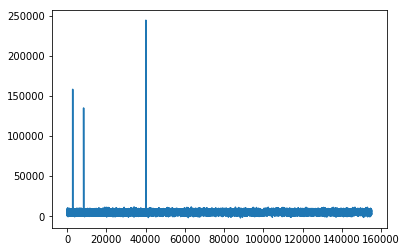

In [7]:
# this chart clearly shows three transactions with an abnormal amount:

plt.plot(df_transactions.index, df_transactions.amount)

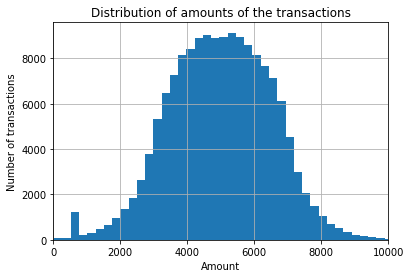

In [8]:
# The distribution of amounts has an anomaly at values between 600 and 700 EUR:

df_transactions.hist('amount', bins=1000)
plt.title('Distribution of amounts of the transactions')

plt.xlim(0, 10000) # 5-800
plt.xlabel('Amount')
plt.ylabel('Number of transactions')
plt.show()

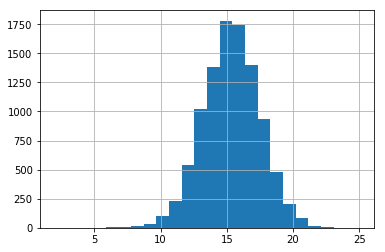

In [9]:
# The distribution of the number of transactions per customer:

transactions_per_customer = df_transactions[df_transactions.customer_id <> 5860].groupby(['customer_id'])['amount'].count()

transactions_per_customer.hist(bins=24)

#plt.xlim(0, 25)

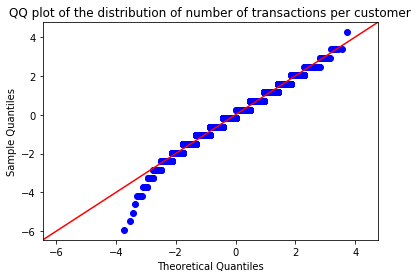

In [10]:
# This is interesting. The distirbution of the number of transactions per customer has a tail for low quantiles. 
# It may indicate fraud? (perhaps, someone who do not usually use the card that has been stolen...)

sm.qqplot(transactions_per_customer, fit=True, line='45')
plt.title('QQ plot of the distribution of number of transactions per customer')
plt.show()

## table of customers:

In [11]:
# Here I'm building 23 clusters of 173*3*13=6747 rows. The idea behind it is that the transactions 
#must be more or less equally distribuited on time. Of course, this don't let us detect anomalies such as 
# an outlier in the number of transactions in a particular day, but at least we can measure if the number of transactions
# is abnormal for some customer and for some cluster.

# Please note that I only chose 6747 because this gives a number of clusters with an equal number of transactions.

df_transactions['cluster'] = df_transactions.apply(lambda row: row.name / (173*3*13), axis=1)

df_transactions['cluster'].max()

22

In [12]:
# I am creating a table having a customer_id for each customer_id, and as columns the following metrics:
# total_amount: total_amount of transactions
# total_transactions: total number of transactions made by that customer
# amount_credit: total amount of credit  
# amount_debit: total amount of debit   
# transactions_credit: total count of credits  
# transactions_debit: total count of debits  
# amount_per_transaction: average amount of a single transaction
# amount_%_credit: amount of credit over the total amount of transactions made by the customer
# transactions_%_credit: number of credit transactions over the total number of transactions
# max_amount_credit: maximum amount of a credit transaction made by the customer
# max_amount_debit: maximum amount of a debit transaction
# transactions_credit_RO, amount_credit_RO, transactions_debit_RO, amount_debit_RO: number of credit/debit transactions and corresponding total amount for transations with counterparty in Romania
# transactions_credit_SE/FI/DK, amount_credit_SE/FI/DK, transactions_debit_SE/FI/DK, amount_debit_SE/FI/DK: same as above
# max_transactions_cluster: maximum number of transactions among all the clusters
# mean_transactions_cluster: average number of transactions on all the clusters
# max_transactions_cluster_%_of_total: percentage of transactions covered by the cluster with maximum number of transactions
# max_amount_per_cluster: maximum amount among all the clusters
# mean_amount_per_cluster: average amount on all the clusters
# max_amount_cluster_%_of_total: percentage of amount covered by the cluster with maximum amount


In [13]:
customers = df_transactions.groupby(['customer_id'])[['amount', 'credit']].agg(
    {'credit': 'count', 'amount': 'sum'}).reset_index().rename(
    columns={'amount': 'total_amount', 'credit': 'total_transactions'})

In [14]:
customer_debit = df_transactions.groupby(['customer_id', 'credit'])[['amount', 'cluster']].agg(
    {'cluster': 'count', 'amount': 'sum'}).reset_index()

customers = customers.merge(customer_debit[customer_debit.credit == 'Credit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_credit', 'amount': 'amount_credit'}).fillna(0).drop('credit', axis=1)

customers = customers.merge(customer_debit[customer_debit.credit == 'Debit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_debit', 'amount': 'amount_debit'}).fillna(0).drop('credit', axis=1)

In [15]:
customers['amount_per_transaction'] = customers.total_amount / customers.total_transactions
customers['amount_%_credit'] = customers.amount_credit / customers.total_amount
customers['transactions_%_credit'] = customers.transactions_credit / customers.total_transactions

In [16]:
customer_max = df_transactions.groupby(['customer_id', 'credit'])['amount'].max().reset_index()

customers = customers.merge(customer_max[customer_max.credit == 'Credit'], on='customer_id', how='left').rename(
    columns={'amount': 'max_amount_credit'}).fillna(0).drop('credit', axis=1)

customers = customers.merge(customer_max[customer_max.credit == 'Debit'], on='customer_id', how='left').rename(
    columns={'amount': 'max_amount_debit'}).fillna(0).drop('credit', axis=1)

In [17]:
# Romania

customers_RO = df_transactions[df_transactions.counterparty_country == 'RO'].groupby(['customer_id', 'credit'])[['amount', 'cluster']].agg(
    {'cluster': 'count', 'amount': 'sum'}).reset_index()

customers = customers.merge(customers_RO[customers_RO.credit == 'Credit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_credit_RO', 'amount': 'amount_credit_RO'}).fillna(0).drop('credit', axis=1)

customers = customers.merge(customers_RO[customers_RO.credit == 'Debit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_debit_RO', 'amount': 'amount_debit_RO'}).fillna(0).drop('credit', axis=1)

# Sweden

customers_SE = df_transactions[df_transactions.counterparty_country == 'SE'].groupby(
    ['customer_id', 'credit'])[['amount', 'cluster']].agg(
    {'cluster': 'count', 'amount': 'sum'}).reset_index()

customers = customers.merge(customers_SE[customers_SE.credit == 'Credit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_credit_SE', 'amount': 'amount_credit_SE'}).fillna(0).drop('credit', axis=1)

customers = customers.merge(customers_SE[customers_SE.credit == 'Debit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_debit_SE', 'amount': 'amount_debit_SE'}).fillna(0).drop('credit', axis=1)

# Finland

customers_FI = df_transactions[df_transactions.counterparty_country == 'FI'].groupby(
    ['customer_id', 'credit'])[['amount', 'cluster']].agg(
    {'cluster': 'count', 'amount': 'sum'}).reset_index()

customers = customers.merge(customers_FI[customers_FI.credit == 'Credit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_credit_FI', 'amount': 'amount_credit_FI'}).fillna(0).drop('credit', axis=1)

customers = customers.merge(customers_FI[customers_FI.credit == 'Debit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_debit_FI', 'amount': 'amount_debit_FI'}).fillna(0).drop('credit', axis=1)

# Finland

customers_DK = df_transactions[df_transactions.counterparty_country == 'DK'].groupby(
    ['customer_id', 'credit'])[['amount', 'cluster']].agg(
    {'cluster': 'count', 'amount': 'sum'}).reset_index()

customers = customers.merge(customers_DK[customers_DK.credit == 'Credit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_credit_DK', 'amount': 'amount_credit_DK'}).fillna(0).drop('credit', axis=1)

customers = customers.merge(customers_FI[customers_FI.credit == 'Debit'], on='customer_id', how='left').rename(
    columns={'cluster': 'transactions_debit_DK', 'amount': 'amount_debit_DK'}).fillna(0).drop('credit', axis=1)

In [18]:
transactions_per_cluster = df_transactions.groupby(
    ['customer_id', 'cluster'])['amount'].count().unstack().fillna(0)

customers['max_transactions_cluster'] = transactions_per_cluster.max(axis=1)
customers['mean_transactions_cluster'] = transactions_per_cluster.mean(axis=1)
customers['max_transactions_cluster_%_of_total'] = customers.max_transactions_cluster / customers.total_transactions

In [19]:
amount_per_cluster = df_transactions.groupby(
    ['customer_id', 'cluster'])['amount'].sum().unstack().fillna(0)

customers['max_amount_per_cluster'] = amount_per_cluster.max(axis=1)
customers['mean_amount_cluster'] = amount_per_cluster.mean(axis=1)
customers['max_amount_cluster_%_of_total'] = customers.max_amount_per_cluster / customers.total_amount

len(customers.columns)

34

In [20]:
customers.sort_values('max_amount_cluster_%_of_total', ascending=False)[:10]

,customer_id,total_transactions,total_amount,transactions_credit,amount_credit,transactions_debit,amount_debit,amount_per_transaction,amount_%_credit,transactions_%_credit,...,transactions_credit_DK,amount_credit_DK,transactions_debit_DK,amount_debit_DK,max_transactions_cluster,mean_transactions_cluster,max_transactions_cluster_%_of_total,max_amount_per_cluster,mean_amount_cluster,max_amount_cluster_%_of_total
1519,1519,20,316895,12.0,45111.0,8.0,271784.0,15844.750000,0.142353,0.600000,...,6.0,22716.0,4.0,15570.0,2.0,0.869565,0.100000,248316.0,13778.043478,0.783591
570,570,17,250669,8.0,44386.0,9.0,206283.0,14745.235294,0.177070,0.470588,...,3.0,16420.0,6.0,35651.0,2.0,0.739130,0.117647,158208.0,10898.652174,0.631143
2985,2985,5,29475,2.0,11883.0,3.0,17592.0,5895.000000,0.403155,0.400000,...,1.0,6152.0,1.0,5619.0,3.0,0.217391,0.600000,17592.0,1281.521739,0.596845
497,497,6,17283,4.0,10378.0,2.0,6905.0,2880.500000,0.600474,0.666667,...,3.0,7328.0,1.0,3553.0,4.0,0.260870,0.666667,9691.0,751.434783,0.560724
2845,2845,18,247215,14.0,219571.0,4.0,27644.0,13734.166667,0.888178,0.777778,...,5.0,32850.0,0.0,0.0,2.0,0.782609,0.111111,134929.0,10748.478261,0.545796
8816,8816,2,6637,2.0,6637.0,0.0,0.0,3318.500000,1.000000,1.000000,...,2.0,6637.0,0.0,0.0,1.0,0.086957,0.500000,3431.0,288.565217,0.516950
4612,4612,7,40643,1.0,5342.0,6.0,35301.0,5806.142857,0.131437,0.142857,...,0.0,0.0,3.0,18175.0,3.0,0.304348,0.428571,18687.0,1767.086957,0.459784
111,111,10,61411,4.0,22086.0,6.0,39325.0,6141.100000,0.359642,0.400000,...,0.0,0.0,1.0,7174.0,3.0,0.434783,0.300000,23130.0,2670.043478,0.376643
5958,5958,8,34084,5.0,20999.0,3.0,13085.0,4260.500000,0.616096,0.625000,...,2.0,4411.0,0.0,0.0,3.0,0.347826,0.375000,12341.0,1481.913043,0.362076
1223,1223,3,18245,2.0,12486.0,1.0,5759.0,6081.666667,0.684352,0.666667,...,2.0,12486.0,0.0,0.0,1.0,0.130435,0.333333,6534.0,793.260870,0.358126


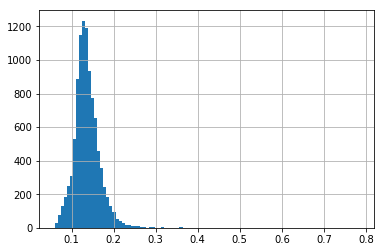

In [21]:
# this is interesting. This following metric show some not intuitive outliers. For example, customer ID 2985 made 5 
# transactions only in the first two clusters, then stopped. Of course it can be a false positive, 
# but it's something to analyze better.

customers['max_amount_cluster_%_of_total'].hist(bins=100)

plt.show()

In [22]:
# trying pca - with no much hope..

x = StandardScaler().fit_transform(customers[['total_transactions', 'total_amount',
                                             'amount_per_transaction', 'max_amount_credit', 'max_amount_debit',
                                             'amount_%_credit', 'transactions_%_credit', 'max_transactions_cluster',
                                             'max_transactions_cluster_%_of_total']])
columns = ['principal component {}'.format(i) for i in range (1, 10)]

pca = PCA(n_components=9)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

principalDf[:5]
#pca.explained_variance_ratio_

C:\Users\MaurizioRagusa\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\MaurizioRagusa\Anaconda2\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9
0,-0.453873,0.079663,0.665579,-0.888121,0.050022,0.173984,-0.363510,-0.123647,0.050127
1,-0.694863,1.035349,-0.762460,0.184292,0.091827,-0.053722,0.011388,0.171884,-0.010036
2,-0.571983,0.147789,0.510812,-0.477323,0.052100,-0.436678,-0.141082,0.040575,0.007681
3,-2.346906,-2.362316,3.347930,5.315798,0.318270,-0.226515,0.078021,0.048760,0.152843
4,-0.955216,0.970294,-0.770182,0.914359,-0.016380,-0.136560,0.194428,0.001466,-0.011407


In [23]:
# indeed, the first components explain just a low portion of the variance.

pca.explained_variance_ratio_

array([3.02450801e-01, 2.22608470e-01, 2.21316589e-01, 1.14459064e-01,
       8.24700099e-02, 4.35048765e-02, 1.09942095e-02, 2.09262393e-03,
       1.03355840e-04])

### Running the Local Outlier Factor to detect anomalies

In [24]:
# model specification
model = LocalOutlierFactor(n_neighbors = 20, metric = "euclidean", contamination = 0.01)
# model fitting
y_pred = model.fit_predict(customers[[#'total_transactions', 'total_amount',
                                      'amount_per_transaction', 'max_amount_credit', 'max_amount_debit',
                                      'max_transactions_cluster',
                                      'transactions_credit_RO', 'amount_credit_RO','transactions_debit_RO', 'amount_debit_RO',
                                      'transactions_credit_FI', 'amount_credit_FI','transactions_debit_FI', 'amount_debit_FI',
                                      'transactions_credit_SE', 'amount_credit_SE','transactions_debit_SE', 'amount_debit_SE',
                                      'transactions_credit_DK', 'amount_credit_DK','transactions_debit_DK', 'amount_debit_DK',
                                      'max_transactions_cluster', 'max_amount_per_cluster']])

customers['outlier'] = model.negative_outlier_factor_

In [25]:
# filter outlier index
outlier_index = np.where(y_pred == -1) # negative values are outliers and positives inliers
# filter outlier values
outlier_values = customers.iloc[outlier_index]
# plot data
#plt.scatter(df["x"], df["y"], color = "b", s = 65)
# plot outlier values
#plt.scatter(outlier_values["x"], outlier_values["y"], color = "r")

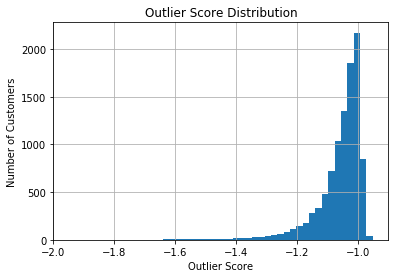

In [26]:
customers.outlier.hist(bins=1000)
plt.xlim(-2, -0.9)
plt.title('Outlier Score Distribution')
plt.xlabel('Outlier Score')
plt.ylabel('Number of Customers')
plt.show()

In [27]:
median_outlier = customers.outlier.median()
dev_outlier = customers.outlier.std()

In [28]:
# assign the fraud class to each customer, basing on their outlier score.
# 0: low risk of fraud 
# 1: moderate risk of fraud
# 2: high risk of fraud

def assign_fraud_class(outlier_score, median, dev):
    
    if np.abs(outlier_score - median) <= 2 * dev:
        
        return 0
    
    elif np.abs(outlier_score - median) <= 3 * dev: 
        
        return 1
    
    else:
        
        return 2

In [29]:
customers['fraud_class'] = customers['outlier'].apply(lambda outlier_score: assign_fraud_class(
    outlier_score, customers.outlier.median(), customers.outlier.std()))

In [30]:
customers[['total_transactions', 'total_amount',
                                      'amount_per_transaction', 'max_amount_credit', 'max_amount_debit',
                                      'max_transactions_cluster',
                                      'transactions_credit_RO', 'amount_credit_RO','transactions_debit_RO', 'amount_debit_RO',
                                      'transactions_credit_FI', 'amount_credit_FI','transactions_debit_FI', 'amount_debit_FI',
                                      'transactions_credit_SE', 'amount_credit_SE','transactions_debit_SE', 'amount_debit_SE',
                                      'transactions_credit_DK', 'amount_credit_DK','transactions_debit_DK', 'amount_debit_DK',
                                      'max_transactions_cluster_%_of_total', 'outlier', 'fraud_class']].sort_values(
    'outlier')[:20]

,total_transactions,total_amount,amount_per_transaction,max_amount_credit,max_amount_debit,max_transactions_cluster,transactions_credit_RO,amount_credit_RO,transactions_debit_RO,amount_debit_RO,...,amount_credit_SE,transactions_debit_SE,amount_debit_SE,transactions_credit_DK,amount_credit_DK,transactions_debit_DK,amount_debit_DK,max_transactions_cluster_%_of_total,outlier,fraud_class
1519,20,316895,15844.750000,4357.0,244351.0,2.0,0.0,0.0,0.0,0.0,...,7484.0,3.0,11863.0,6.0,22716.0,4.0,15570.0,0.100000,-21.803897,2
5860,1123,812972,723.928762,6591.0,6759.0,294.0,0.0,0.0,0.0,0.0,...,165212.0,172.0,120098.0,219.0,155426.0,148.0,99290.0,0.261799,-19.020865,2
570,17,250669,14745.235294,6328.0,158208.0,2.0,0.0,0.0,1.0,158208.0,...,17724.0,0.0,0.0,3.0,16420.0,6.0,35651.0,0.117647,-18.518983,2
2845,18,247215,13734.166667,134929.0,7521.0,2.0,1.0,134929.0,0.0,0.0,...,12134.0,1.0,6836.0,5.0,32850.0,0.0,0.0,0.111111,-14.325989,2
3306,16,93925,5870.312500,6243.0,8539.0,2.0,0.0,0.0,5.0,23232.0,...,10053.0,3.0,22335.0,2.0,12213.0,2.0,12128.0,0.125000,-2.519969,2
4473,21,113587,5408.904762,7930.0,7781.0,2.0,5.0,21439.0,2.0,8555.0,...,6940.0,2.0,11782.0,2.0,10508.0,5.0,30955.0,0.095238,-2.501109,2
2399,19,131093,6899.631579,8868.0,7682.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5385.0,4.0,28460.0,4.0,25657.0,0.105263,-2.332843,2
5030,18,64669,3592.722222,7031.0,5002.0,2.0,3.0,9831.0,3.0,10163.0,...,6290.0,5.0,15580.0,3.0,16946.0,1.0,3829.0,0.111111,-2.331330,2
984,18,104215,5789.722222,7434.0,7227.0,2.0,2.0,8116.0,4.0,17934.0,...,20067.0,3.0,17837.0,1.0,6468.0,3.0,19528.0,0.111111,-2.256893,2
9549,16,58898,3681.125000,3875.0,4682.0,2.0,4.0,14308.0,1.0,4064.0,...,3875.0,5.0,19272.0,0.0,0.0,2.0,6834.0,0.125000,-2.222315,2


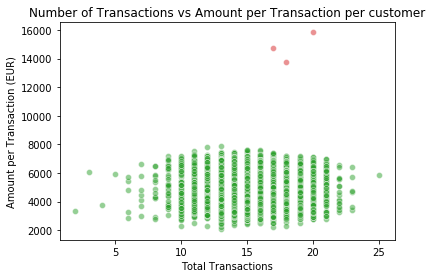

In [31]:
plt.figure(figsize=(6, 4))

ax = sns.scatterplot(x='total_transactions', y='amount_per_transaction', 
                     #hue=countries_cr_std['confirmation_id'][:30],
                     data=customers[customers.customer_id <> 5860].sort_values('outlier')[:3],
                     color='tab:red', palette='summer', alpha=0.5)

ax = sns.scatterplot(x='total_transactions', y='amount_per_transaction', 
                     #hue=countries_cr_std['confirmation_id'][:30],
                     data=customers[customers.customer_id <> 5860].sort_values('outlier')[3:],
                     color='tab:green', palette='summer', alpha=0.5)

plt.xlabel('Total Transactions')
plt.ylabel('Amount per Transaction (EUR)')
plt.title('Number of Transactions vs Amount per Transaction per customer')
plt.show()

## Sequence analysis attempt

In [32]:
# this dataframe represents, for each customer, the sequence of transactions (truncated to 25, which excludes  
# only one customer, clearly an outlier with over than 1000 transactions) made by it.It would be interesting
# to study it as well, in order to understand if there have been anomalies in the transactional behavior of the customers.

sequence = df_transactions.groupby('customer_id').amount_tilde.agg(list).to_frame()
sequence['amount_tilde_truncated'] = sequence['amount_tilde'].apply(lambda lis: lis[:25])

sequence_transitions = sequence['amount_tilde_truncated'].apply(pd.Series)
sequence_transitions = sequence_transitions.fillna(0)

sequence_transitions[:5]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
customer_id,,,,,,,,,,,,,,,,,,,,,
0,5702.0,3622.0,-3561.0,-2879.0,4708.0,4641.0,3155.0,-2960.0,3945.0,-5345.0,...,-5070.0,-3516.0,-4602.0,3418.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3098.0,-5265.0,5240.0,-5860.0,-3561.0,-4153.0,-5969.0,-4508.0,-4574.0,4560.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4836.0,4225.0,-4608.0,4168.0,4349.0,-4755.0,4440.0,-4737.0,4799.0,4328.0,...,4540.0,-4674.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-4210.0,4527.0,4189.0,3313.0,4634.0,2759.0,4953.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-4912.0,-4892.0,4538.0,5085.0,-4395.0,-5569.0,-5133.0,-4114.0,4342.0,5147.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# outlier detection for sequence of transactions

# model specification
model = LocalOutlierFactor(n_neighbors = 20, metric = "euclidean", contamination = 0.01)
# model fitting
y_pred = model.fit_predict(sequence_transitions)

sequence_transitions['outlier'] = model.negative_outlier_factor_

sequence_transitions.sort_values('outlier', ascending=True)[:20]

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,outlier
customer_id,,,,,,,,,,,,,,,,,,,,,
1519,3788.0,4046.0,3395.0,3471.0,3708.0,-3965.0,-244351.0,-4133.0,-3435.0,3537.0,...,3776.0,-3765.0,-4702.0,-3749.0,0.0,0.0,0.0,0.0,0.0,-13.858757
570,-158208.0,-5694.0,6328.0,5505.0,-6550.0,6144.0,-6148.0,5548.0,-6009.0,-5874.0,...,-5574.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.258476
2845,6316.0,134929.0,6288.0,7120.0,4739.0,7006.0,7466.0,7395.0,6648.0,6833.0,...,-6280.0,5526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.804063
8286,6395.0,6264.0,6190.0,-5945.0,6153.0,5495.0,-6470.0,5195.0,6490.0,6310.0,...,6248.0,-6686.0,-5626.0,5054.0,5105.0,7043.0,6966.0,6096.0,-5015.0,-1.780099
7170,-6288.0,6874.0,-4237.0,5962.0,8542.0,6735.0,-7992.0,-7064.0,-7605.0,-8204.0,...,5611.0,4584.0,7149.0,-6510.0,-8702.0,0.0,0.0,0.0,0.0,-1.746054
6190,5413.0,-6850.0,-7085.0,-7216.0,5285.0,7055.0,-6475.0,-6180.0,6047.0,-5961.0,...,7040.0,5326.0,6465.0,7597.0,8225.0,-5057.0,0.0,0.0,0.0,-1.698468
4423,-5938.0,-6174.0,-6491.0,6215.0,6031.0,-6613.0,-6726.0,7102.0,6557.0,-5774.0,...,-6901.0,-6850.0,-6304.0,6736.0,6601.0,0.0,0.0,0.0,0.0,-1.695947
5494,5388.0,-5329.0,8117.0,-4173.0,-6791.0,6138.0,6041.0,8289.0,-3311.0,-6979.0,...,8613.0,-8900.0,-3933.0,7497.0,-7930.0,0.0,0.0,0.0,0.0,-1.688859
330,-6925.0,-5904.0,7685.0,6456.0,6734.0,-5717.0,5886.0,-6125.0,-7814.0,-6119.0,...,7580.0,-8965.0,-8809.0,6165.0,-5497.0,0.0,0.0,0.0,0.0,-1.670116


In [34]:
# Attempt for a pca, but it does not lead to anything interesting because the explained variance ratio is 
# distributed across too many eigenvectors :/

x = StandardScaler().fit_transform(sequence_transitions)
columns = ['principal component {}'.format(i) for i in range (1, 26)]
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

principalDf[:5]
#pca.explained_variance_ratio_

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,principal component 21,principal component 22,principal component 23,principal component 24,principal component 25
0,0.006467,-0.684276,-0.193893,-0.517349,0.624726,-0.211841,0.176891,-0.686921,1.907004,-1.784037,...,0.234345,-0.426623,0.271254,-1.520569,-0.832635,-2.129402,0.245215,-0.351608,0.651736,0.091391
1,0.015244,0.031029,-0.274853,0.134624,0.551550,1.673460,-0.192469,-0.715126,-0.112874,0.756012,...,0.283296,-0.134347,-0.449935,-0.548976,0.413225,0.459638,-0.724852,-0.136786,-0.679642,0.033670
2,-0.078899,-0.663620,0.315882,0.290397,-0.919994,0.103405,0.325074,1.386726,-0.890159,-1.735078,...,-0.752995,0.170927,-0.101646,-0.671129,-1.251446,-0.582546,0.909887,-0.177297,0.794572,-0.017610
3,-0.013186,-0.618963,-0.206897,-0.243167,0.078941,0.078435,0.569008,0.585594,-0.364320,-0.649831,...,-0.210717,0.833049,0.777376,0.537711,-0.547128,0.002009,-0.300030,0.188440,-0.456154,0.037044
4,-0.063770,0.314497,-0.294750,-0.363513,-1.046284,0.812829,-0.941693,1.405247,-0.688525,-0.344761,...,1.454553,0.011037,-0.888244,0.216420,0.188578,-0.246318,-0.283376,-0.056714,-0.940910,0.088087


In [35]:
pca.explained_variance_ratio_

array([0.09752161, 0.05058048, 0.04557261, 0.04211919, 0.0413378 ,
       0.04082609, 0.04039469, 0.03996787, 0.03956771, 0.03904456,
       0.03891823, 0.03885419, 0.03853515, 0.0381646 , 0.0374613 ,
       0.03717441, 0.03693607, 0.03652125, 0.03628546, 0.03599053,
       0.03557931, 0.03496916, 0.02844647, 0.02688381, 0.02136467])

## Analysis of distribution of data in clusters

In [36]:
# Here I'm trying to understand if there are some macroscopic change in the distribution of data across the time
# To do that, I'm rescaling the cluster number in order to have more clusters.

df_transactions['cluster'] = df_transactions.apply(lambda row: row.name / (173*3), axis=1)

clusters_agg = df_transactions.groupby(
    ['cluster', 'credit', 'counterparty_country'])[['customer_id', 'amount']].agg(
    {'customer_id': 'count', 'amount': 'sum'}).reset_index()

means = clusters_agg.groupby(['credit', 'counterparty_country'])[['amount', 'customer_id']].mean().reset_index()
stds = clusters_agg.groupby(['credit', 'counterparty_country'])[['amount', 'customer_id']].std().reset_index()

sums_cluster = clusters_agg.groupby(
    ['cluster', 'credit'])[['amount', 'customer_id']].sum().reset_index()

clusters_agg = clusters_agg.merge(means, on=['credit', 'counterparty_country'], how='left', suffixes=['', '_mean'])
clusters_agg = clusters_agg.merge(stds, on=['credit', 'counterparty_country'], how='left', suffixes=['', '_std'])

clusters_agg = clusters_agg.merge(
    sums_cluster, on=['cluster', 'credit'], how='left', suffixes=['', '_sum_cluster'])

# I say that one cluster is at risk if the number of transactions / amount in that cluster deviates more than 3*std from 
# the mean.
clusters_agg['count_transactions_at_risk'] = clusters_agg.apply(lambda row: 0 if np.abs(row.customer_id_mean - row.customer_id) <= row.customer_id_std * 3 else 1, axis=1)
clusters_agg['amount_at_risk'] = clusters_agg.apply(lambda row: 0 if np.abs(row.amount_mean - row.amount) <= row.amount_std * 3 else 1, axis=1)

clusters_agg['amount_perc'] = clusters_agg.amount / clusters_agg.amount_sum_cluster
clusters_agg['customer_id_perc'] = clusters_agg.customer_id / clusters_agg.customer_id_sum_cluster

In [37]:
clusters_agg[clusters_agg.count_transactions_at_risk == 1]

,cluster,credit,counterparty_country,amount,customer_id,amount_mean,customer_id_mean,amount_std,customer_id_std,amount_sum_cluster,customer_id_sum_cluster,count_transactions_at_risk,amount_at_risk,amount_perc,customer_id_perc
35,5,Credit,SE,519966,115,428834.839465,86.150502,47829.825560,8.961182,1306897,289,1,0,0.397863,0.397924
392,57,Credit,RO,12129,4,5306.881890,1.377953,11769.098791,0.589984,1309619,270,1,0,0.009261,0.014815
869,127,Debit,RO,8079,3,5098.736000,1.248000,13924.269405,0.518310,1210988,247,1,0,0.006671,0.012146
1408,206,Debit,RO,11352,3,5098.736000,1.248000,13924.269405,0.518310,1344279,277,1,0,0.008445,0.010830
1443,211,Debit,RO,6698,3,5098.736000,1.248000,13924.269405,0.518310,1248883,258,1,0,0.005363,0.011628
1672,244,Debit,RO,7861,3,5098.736000,1.248000,13924.269405,0.518310,1304851,267,1,0,0.006024,0.011236
1935,282,Debit,SE,573155,111,427809.498328,85.916388,41650.687184,8.010670,1386547,268,1,1,0.413369,0.414179
1941,283,Debit,RO,9069,3,5098.736000,1.248000,13924.269405,0.518310,1320922,273,1,0,0.006866,0.010989
2040,298,Credit,DK,544438,113,427294.555184,85.812709,43304.609057,8.504936,1322020,268,1,0,0.411823,0.421642


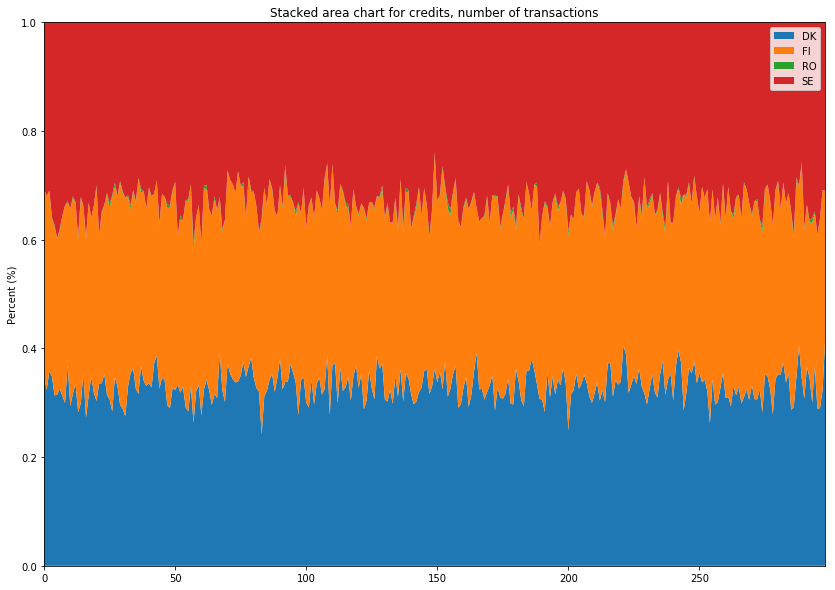

In [38]:
# this chart will show possible anomalies in the distribution of transactions among the four counterparty countries: 

pivot_credit_count = clusters_agg[clusters_agg.credit == 'Credit'].pivot(
    index ='cluster', columns = 'counterparty_country', values = ['customer_id_perc']).fillna(0).droplevel(level=0, axis=1)

plt.figure(figsize=(14, 10))

#ax = pivot_credit_count.plot(kind='area', stacked=True, title='100 % stacked area chart')
plt.stackplot(pivot_credit_count.index, pivot_credit_count.DK, 
             pivot_credit_count.FI, pivot_credit_count.RO, pivot_credit_count.SE, labels=['DK', 'FI', 'RO', 'SE'])
plt.title('Stacked area chart for credits, number of transactions')
plt.ylabel('Percent (%)')
plt.margins(0, 0) # Set margins to avoid "whitespace"
plt.legend()

plt.show()

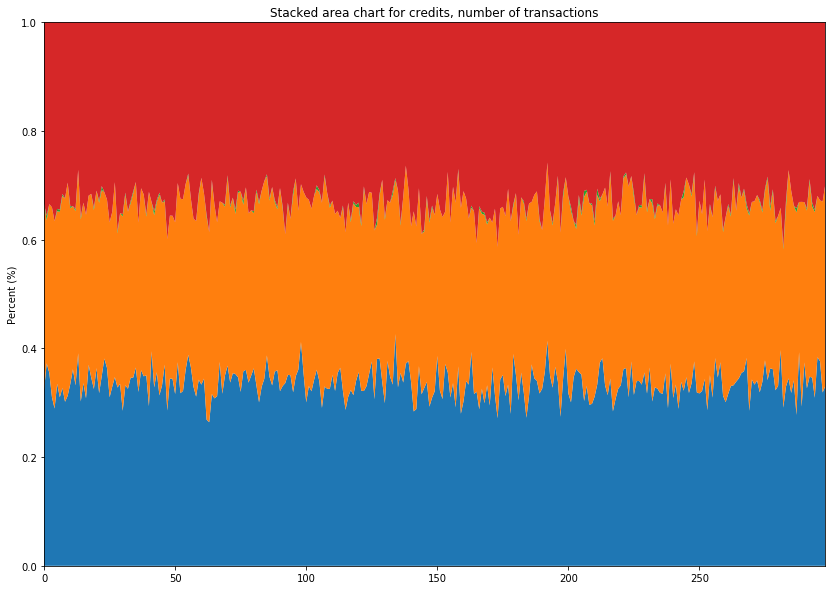

In [39]:
pivot_credit_count = clusters_agg[clusters_agg.credit == 'Debit'].pivot(
    index ='cluster', columns = 'counterparty_country', values = ['customer_id_perc']).fillna(0).droplevel(level=0, axis=1)

plt.figure(figsize=(14, 10))

#ax = pivot_credit_count.plot(kind='area', stacked=True, title='100 % stacked area chart')
plt.stackplot(pivot_credit_count.index, pivot_credit_count.DK, 
             pivot_credit_count.FI, pivot_credit_count.RO, pivot_credit_count.SE,  labels=['DK', 'FI', 'RO', 'SE'])
plt.title('Stacked area chart for credits, number of transactions')
plt.ylabel('Percent (%)')
plt.margins(0, 0) # Set margins to avoid "whitespace"

plt.show()

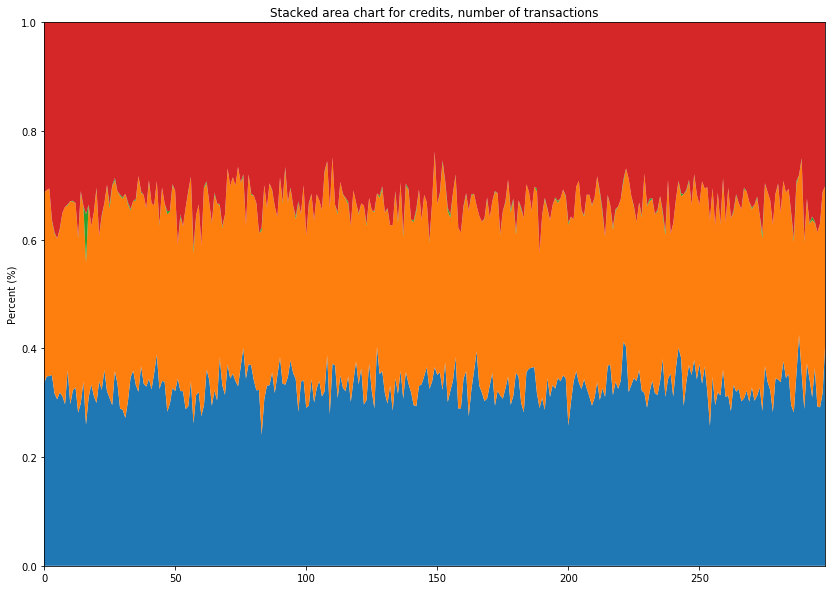

In [40]:
pivot_credit_count = clusters_agg[clusters_agg.credit == 'Credit'].pivot(
    index ='cluster', columns = 'counterparty_country', values = ['amount_perc']).fillna(0).droplevel(level=0, axis=1)

plt.figure(figsize=(14, 10))

#ax = pivot_credit_count.plot(kind='area', stacked=True, title='100 % stacked area chart')
plt.stackplot(pivot_credit_count.index, pivot_credit_count.DK, 
             pivot_credit_count.FI, pivot_credit_count.RO, pivot_credit_count.SE, labels=['DK', 'FI', 'RO', 'SE'])
plt.title('Stacked area chart for credits, number of transactions')
plt.ylabel('Percent (%)')
plt.margins(0, 0) # Set margins to avoid "whitespace"

plt.show()

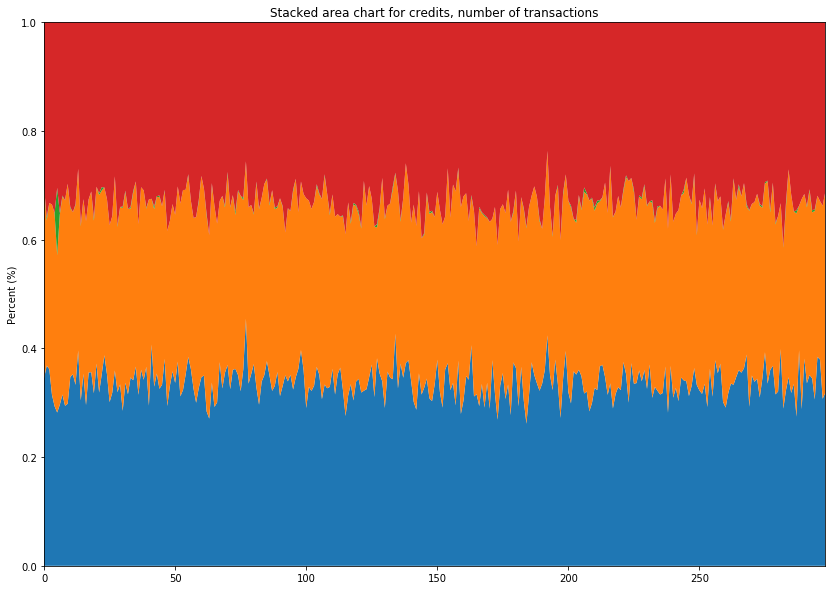

In [41]:
pivot_credit_count = clusters_agg[clusters_agg.credit == 'Debit'].pivot(
    index ='cluster', columns = 'counterparty_country', values = ['amount_perc']).fillna(0).droplevel(level=0, axis=1)

plt.figure(figsize=(14, 10))

#ax = pivot_credit_count.plot(kind='area', stacked=True, title='100 % stacked area chart')
plt.stackplot(pivot_credit_count.index, pivot_credit_count.DK, 
             pivot_credit_count.FI, pivot_credit_count.RO, pivot_credit_count.SE,  labels=['DK', 'FI', 'RO', 'SE'])
plt.title('Stacked area chart for credits, number of transactions')
plt.ylabel('Percent (%)')
plt.margins(0, 0) # Set margins to avoid "whitespace"

plt.show()